# Design and simulation of superconducting co-planar waveguide resonators

## 1 - Calculating of CPW resonator properties

The equations used within this notebook and their corresponding references can be found in this document,
[REF]

### Imports

In [68]:
from scipy.special import ellipk
import math
from tabulate import tabulate
import numpy as np
import cmath

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
from IPython.display import HTML, display

### Classes

In [69]:
class Conductor:
    """CPW conductor material class"""

    def __init__(self, material, criticalTemperature, londonPenetrationDepthZero, resistancePerUnitLength,
                 conductancePerUnitLength, amplitudeAttenuationPerUnitLength):
        self.material = material
        self.criticalTemperature = criticalTemperature
        self.londonPenetrationDepthZero = londonPenetrationDepthZero
        self.resistancePerUnitLength = resistancePerUnitLength
        self.conductancePerUnitLength = conductancePerUnitLength
        self.amplitudeAttenuationPerUnitLength = amplitudeAttenuationPerUnitLength

In [70]:
class Substrate:
    """Substrate material class"""

    def __init__(self, material, relativePermittivity):
        self.material = material
        self.relativePermittivity = relativePermittivity

In [71]:
class CPWResonator:
    """Coplanar wave-guide resonator class"""

    def __init__(self, length, conductorWidth, gapWidth, conductorThickness, resonatorType,
                 conductorMaterial='Niobium', substrateMaterial='Silicon',
                 temperature=4, couplingCapacitance=0E0, loadImpedance=50, loadBoundaryCondition='Short', modes=1):
        # Supplied parameters
        self.length = np.array(length)
        self.conductorWidth = np.array(conductorWidth)
        self.gapWidth = np.array(gapWidth)
        self.conductorThickness = np.array(conductorThickness)
        self.resonatorType = np.array(resonatorType)
        self.conductor = self.conductorProperties(conductorMaterial)
        self.substrate = self.substrateProperties(substrateMaterial)
        self.temperature = np.array(temperature)
        self.couplingCapacitance = np.array(couplingCapacitance)
        self.loadImpedance = np.array(loadImpedance)
        self.loadBoundaryCondition = np.array(loadBoundaryCondition)
        self.modes = np.array(modes)

        # Calculated parameters
        self.effectivePermittivity = self.effectivePermittivity(self.substrate.relativePermittivity)
        self.capacitancePerUnitLength = self.capacitancePerUnitLength(self.conductorWidth, self.gapWidth, self.effectivePermittivity)
        self.geometricInducatancePerUnitLength = self.geometricInducatancePerUnitLength(self.conductorWidth, self.gapWidth)
        self.kineticInductancePerUnitLength = self.kineticInductancePerUnitLength(self.conductorWidth, self.gapWidth, self.conductorThickness,
            self.temperature, self.conductor.criticalTemperature, self.conductor.londonPenetrationDepthZero)
        self.totalInductancePerUnitLength = self.geometricInducatancePerUnitLength + self.kineticInductancePerUnitLength
        self.characteristicImpedance = self.characteristicImpedance(self.totalInductancePerUnitLength, self.capacitancePerUnitLength)
        self.uncoupledResonantFrequency = self.uncoupledResonantFrequency(self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.length,
            self.resonatorType, self.modes)
        self.coupledResonantFrequency = self.coupledResonantFrequency(self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.length,
            self.resonatorType, self.couplingCapacitance, self.loadImpedance, self.modes)
        self.inputImpedance = self.inputImpedance(self.length, self.characteristicImpedance, self.loadBoundaryCondition,
            self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.uncoupledResonantFrequency)
        self.internalQualityFactor = self.internalQualityFactor(self.length, self.resonatorType, self.modes, self.conductor)
        self.externalQualityFactorApprox = self.externalQualityFactorApproxFn(self.resonatorType, self.modes, self.uncoupledResonantFrequency,
            self.couplingCapacitance, self.characteristicImpedance)
        self.externalQualityFactor = self.externalQualityFactorFn(self.uncoupledResonantFrequency,
            self.capacitancePerUnitLength, self.length, self.couplingCapacitance)
        self.externalQualityFactorQWref = self.externalQualityFactorQWrefFn(self.resonatorType, self.modes, self.uncoupledResonantFrequency, self.capacitancePerUnitLength, self.length, 
            self.couplingCapacitance, self.characteristicImpedance)
        self.loadedQualityFactor = self.loadedQualityFactor(self.internalQualityFactor, self.externalQualityFactor)
        self.insertionLoss = self.insertionLoss(self.internalQualityFactor, self.externalQualityFactor)
        self.beta = self.beta(self.uncoupledResonantFrequency, self.totalInductancePerUnitLength, self.capacitancePerUnitLength)

    def effectivePermittivity(self, relativePermittivity):
        return (1 + relativePermittivity)/2

    def capacitancePerUnitLength(self, conductorWidth, gapWidth, effectivePermittivity):
        # Permittivity of free space
        freeSpacePermittivity = 8.85418782E-12

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        k2 = np.sqrt(1 - np.power(k,2))

        # Total CPW capacitance p.u.l.
        return 4 * freeSpacePermittivity * (effectivePermittivity + 0) * (ellipk(k) / ellipk(k2))

    def geometricInducatancePerUnitLength(self, conductorWidth, gapWidth):
        # Permeability of freespace
        freeSpacePermeability = 1.25663706E-6

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        k2 = np.sqrt(1 - np.power(k,2))

        # Total conductor geometric inductance p.u.l.
        return (freeSpacePermeability / 4) * (ellipk(k2) / ellipk(k))

    def kineticInductancePerUnitLength(self, conductorWidth, gapWidth, conductorThickness,
                          temperature, criticalTemperature, londonPenetrationDepthZero):
        # Permeability of freespace
        freeSpacePermeability = 1.25663706E-6

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        K = ellipk(k)

        # Penetration depth at temperature T
        londonPenetrationDepthT = self.londonPenetrationDepthT(temperature, criticalTemperature, londonPenetrationDepthZero)

        # Geometrical factor
        geometricFactor = (1 / (2 * np.power(k, 2) * np.power(K, 2))) * (
            - np.log(conductorThickness / (4 * conductorWidth)) + ((2 * (conductorWidth + gapWidth))
            / (conductorWidth + 2 * gapWidth)) * np.log(gapWidth / (conductorWidth + gapWidth)) - (
            conductorWidth / (conductorWidth + 2 * gapWidth)) * np.log(conductorThickness
            / (4 * (conductorWidth + 2 * gapWidth))))

        # Kinetic Inductance p.u.l.
        return freeSpacePermeability * (np.power(londonPenetrationDepthT, 2) / (conductorWidth * conductorThickness)) * geometricFactor


    def londonPenetrationDepthT(self, temperature, criticalTemperature, londonPenetrationDepthZero):
        return londonPenetrationDepthZero / np.sqrt(1 - np.power((temperature / criticalTemperature), 4))

    def characteristicImpedance(self, inductance, capacitance, resistance=0, conductance=0, frequency=1):
        return np.sqrt(
            (resistance + 1j*2*math.pi*frequency*inductance ) /
            (conductance + 1j*2*math.pi*frequency*capacitance))

    def inputImpedance(self, length, characteristicImpedance, loadBoundaryCondition, inductancePerUnitLength, capacitancePerUnitLength, frequency,
                       resistancePerUnitLength=0, conductancePerUnitLength=0):
        gamma = np.sqrt(
            (resistancePerUnitLength + 1j*2*math.pi*frequency*inductancePerUnitLength ) *
            (conductancePerUnitLength + 1j*2*math.pi*frequency*capacitancePerUnitLength))

        if loadBoundaryCondition == 'Short':
            return characteristicImpedance * np.tanh(gamma*length)
        elif loadBoundaryCondition == 'Open':
            return characteristicImpedance / np.tanh(gamma * length)
        else:
            print('Error: Load boundary condition no valid!')
            return -1

    def uncoupledResonantFrequency(self, totalInductancePerUnitLength, capacitancePerUnitLength, length, resonatorType, modes):
        m = self.getModeFactor(resonatorType, modes)
        return 1 / (np.sqrt(totalInductancePerUnitLength*capacitancePerUnitLength) * m * length)

    def coupledResonantFrequency(self, totalInductancePerUnitLength, capacitancePerUnitLength, length, resonatorType, couplingCapacitance, loadImpedane, modes):
        m = self.getModeFactor(resonatorType, modes)

        # Pre-coupled
        uncoupledResonantFrequency = 1 / (np.sqrt(totalInductancePerUnitLength*capacitancePerUnitLength) * m * length)

        # Post-coupled
        effectiveCouplingCapacitance = self.effectiveCouplingCapacitance(couplingCapacitance, uncoupledResonantFrequency, loadImpedane)

        return 1 / (np.sqrt((totalInductancePerUnitLength*length) * ((capacitancePerUnitLength*length) + effectiveCouplingCapacitance)) * m)

    def effectiveCouplingCapacitance(self, couplingCapacitance, frequency, loadImpedane):
        return couplingCapacitance / \
               (1 + np.power(frequency * couplingCapacitance * loadImpedane * math.pi, 2))

    def internalQualityFactor(self, length, resonatorType, modes, conductor):
        m = self.getModeFactor(resonatorType, modes)
        return (1/m) * (math.pi/(conductor.amplitudeAttenuationPerUnitLength*length))
    
    def externalQualityFactorFn(self, uncoupledResonantFrequency, capacitancePerUnitLength, length, couplingCapacitance, loadResistance=50):
        omega_n = 2 * math.pi * uncoupledResonantFrequency
        r_star = (1+(omega_n*couplingCapacitance*loadResistance)**2) / ((omega_n*couplingCapacitance)**2 * loadResistance)
        C = (capacitancePerUnitLength * length)/2
        return omega_n * r_star * C

    def externalQualityFactorApproxFn(self, resonatorType, modes, uncoupledResonantFrequency, couplingCapacitance, characteristicImpedance):
        m = self.getModeFactor(resonatorType, modes)
        q_in = 2 * math.pi * uncoupledResonantFrequency * couplingCapacitance * characteristicImpedance
        return (1/m) * (math.pi/(q_in**2))

    def externalQualityFactorQWrefFn(self, resonatorType, modes, uncoupledResonantFrequency, capacitancePerUnitLength, length, couplingCapacitance, characteristicImpedance):
        m = self.getModeFactor(resonatorType, modes)
        omega_0 = 2 * math.pi * uncoupledResonantFrequency
        inputPortImpedance = 50
        mBody = 1/(omega_0**2 * couplingCapacitance**2 * characteristicImpedance * inputPortImpedance)
        return (math.pi/m) * mBody
    
    def loadedQualityFactor(self, internalQualityFactor, externalQualityFactor):
        return 1/((1/internalQualityFactor) + (1/externalQualityFactor))

    def getModeFactor(self, resonatorType, modes):
        if resonatorType == 'half':
            m = 4.0 / (2.0 * modes)
        elif resonatorType == 'quarter':
            m = 4.0 / ((2.0 * modes) - 1)
        else:
            print('Error: Incorrect resonator type provided!')
            return -1
        return m

    def insertionLoss(self, internalQualityFactor, externalQualityFactor):
        g = internalQualityFactor/externalQualityFactor
        return -20 * np.log10(g/(g+1))
    
    def beta(self, uncoupledResonantFrequency, inductancePerUnitLength, capacitancePerUnitLength):
        omega_n = 2 * math.pi * uncoupledResonantFrequency
        return omega_n * np.sqrt(inductancePerUnitLength*capacitancePerUnitLength)

    def conductorProperties(self, material):
        return{
            'Niobium': Conductor(material=material, criticalTemperature=9.2, londonPenetrationDepthZero=33.3E-9,
                resistancePerUnitLength=0, conductancePerUnitLength=0, amplitudeAttenuationPerUnitLength=0.0001),
            'Niobium Nitride': Conductor(material=material, criticalTemperature=16.2, londonPenetrationDepthZero=40E-9,
                resistancePerUnitLength=0, conductancePerUnitLength=0, amplitudeAttenuationPerUnitLength=0.0001),
        }[material]

    def substrateProperties(self, material):
        return{
            'Silicon': Substrate(material=material, relativePermittivity=11.9),
            'Sapphire': Substrate(material=material, relativePermittivity=10.2),
        }[material]

## ABCD Transmission matrix

The ABCD matrix can be used to fit the transmission/reflection resonance peaks of a resonator. The matrix is defined as,

\begin{equation}
\begin{bmatrix}
    A & B \\
    C & D
\end{bmatrix}
= 
\begin{bmatrix}
    1 & Z_{in} \\
    0 & 0
\end{bmatrix}
\begin{bmatrix}
    t_{11} & t_{12} \\
    t_{21} & t_{22}
\end{bmatrix}
\begin{bmatrix}
    1 & Z_{out} \\
    0 & 0
\end{bmatrix}
\end{equation}

where, 

\begin{equation}
    t_{11} = t_{22} = \cosh{\gamma l}
\end{equation}

\begin{equation}
    t_{12} = Z_0 \sinh(\gamma l)
\end{equation}

\begin{equation}
    t_{21} = \frac{1}{Z_0} \sinh(\gamma l)
\end{equation}

where $Z_0$ is the characteristic impedance, and $\gamma = \alpha + i \beta$ where $\alpha$ is the amplitude attenuation coefficient and $\beta$ is given by,

\begin{equation}
    \beta = \frac{\omega_n}{v_{ph}} = \omega_n \sqrt{L_l C_l} = \omega_n \frac{\sqrt{\epsilon_0}}{c}
\end{equation}

The transmission parameter, $S_{21}$ is then given by,

\begin{equation}
    S_{21} = \frac{2}{A + \frac{B}{R_L} + C R_L + D}
\end{equation}

where $R_L$ is the load resistance.

In [72]:
class ABCD:
    'ABCD matrix method'

    def __init__(self, freq, length, alpha, beta, couplingCapacitance, charImpedance, loadResistance=50):
        self.freq = freq
        self.length = length
        self.gamma = alpha + 1j*beta
        self.couplingCapacitance = couplingCapacitance
        self.charImpedance = charImpedance
        self.loadResistance = loadResistance
        
        self.s21 = self.s21(self.abcd(
            self.input(self.freq, self.couplingCapacitance),
            self.transmission(self.freq, self.length, self.gamma, self.charImpedance),
            self.output(self.freq, self.couplingCapacitance)),
            self.loadResistance)

    def input(self, freq, couplingCapacitance):
        n=np.size(freq)
        Zin = 1/(1j*freq*couplingCapacitance)
        return np.append(np.ones(n),[np.zeros(n),Zin,np.ones(n)]).reshape(n,2,2,order='F')
        
    def output(self, freq, couplingCapacitance):
        n=np.size(freq)
        Zin = 1/(1j*freq*couplingCapacitance)
        return np.append(np.ones(n),[np.zeros(n),Zin,np.ones(n)]).reshape(n,2,2,order='F')
        
    def transmission(self, freq, length, gamma, charImpedance):
        n=np.size(freq)
        t11 = np.cosh(gamma * length)
        t12 = charImpedance * np.sinh(gamma * length)
        t21 = (1/charImpedance) * np.sinh(gamma * length)
        t22 = np.cosh(gamma * length)
        return np.append(t11*np.ones(n),[t21*np.ones(n),t12*np.ones(n),t22*np.ones(n)]) \
            .reshape(n,2,2,order='F')
    
    def abcd(self, input, transmission, output):
        return input*transmission*output
    
    def s21(self, pABCD, loadResistance):
        A = pABCD[:,0,0]
        B = pABCD[:,0,1]
        C = pABCD[:,1,0]
        D = pABCD[:,1,1]
        RL = loadResistance
        return 2/( A + (B/RL)+ (C*RL) + D )

# 2 - Calculating Rydberg atom transition frequencies

The wavelength of the transition between the $n_1$th and $n_2$th levels is given by,

\begin{equation}
    \frac{1}{\lambda} = R_{M} \left( \frac{1}{n_1^2} - \frac{1}{n_1^2} \right)
\end{equation}

where $R_{M}$ is the reduced mass,

\begin{equation}
    R_{M} = \frac{R_{\infty}}{1+\frac{m_e}{M}}
\end{equation}

where $R_{\infty}$ is the Rydberg constant with an infinite mass nucleus, $m_e$ is the electron mass, and $M$ is the mass of the nucleus. $R_{\infty}$ is given by,

\begin{equation}
    R_{\infty} = \frac{m_e e^4}{8 \epsilon_0^2 h^3 c} = 1.0973731568508 \times 10^7 m^{-1}
\end{equation} 

The frequency of the transition is then,

\begin{equation}
    f = \frac{c}{\lambda}
\end{equation}

where $c$ is the speed of light.

In [2]:
class RydbergAtom:
    def __init__(self, z):
        self.z = z
        self.r_inf = 1.0973731568508 * 10**7
        
    def frequency(self, n_from, n_to):
        m_e = 9.10938356 * 10**-31
        m_p = 1.6726219 * 10**-27
        r_m = self.r_inf / (1 + (m_e/(2*self.z*m_p)))
        wavelength = 1 / ( r_m * ( (1/n_from**2) - (1/n_to**2) ) )
        c = 2.99792458 * 10**8
        return c / wavelength

In [16]:
heliumCharge = 2
mAtom = RydbergAtom(heliumCharge)
n = 68
print('Transition frequency (n =', n , '->', n+1, ') is', "%.3f" % (mAtom.frequency(n, n+1)/10**9), 'GHz')

Transition frequency (n = 68 -> 69 ) is 20.470 GHz


# 3 - Relationships between CPW resonator properties

## Default values

In [166]:
default = {'length': [7208E-6],
           'conductorWidth': [20E-6],
           'gapWidth': [10E-6],
           'conductorThickness': [100E-9],
           'resonatorType': 'quarter',
           'conductorMaterial': 'Niobium Nitride',
           'substrateMaterial': 'Silicon',
           'temperature': [4],
           'couplingCapacitance': [10E-15],
           'loadBoundaryCondition': 'Short',
           'modes': [1]}    

## Lengths for $\lambda / 2$ and $\lambda / 4$ resonators

In [167]:
mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=[1,2,3,4,5])

def length(frequency, resonatorType):
    c = 2.99792458 * 10**8
    m = mCPW.getModeFactor(resonatorType, mCPW.modes)
    return (c / np.sqrt(mCPW.effectivePermittivity)) / (m * frequency)

heliumCharge = 2
mAtom = RydbergAtom(heliumCharge)
n = 68

qwLengths = length(mAtom.frequency(n, n+1), 'quarter')
hwLengths = length(mAtom.frequency(n, n+1), 'half')
c = 2.99792458 * 10**8 

print('Frequency: ', mAtom.frequency(n, n+1)/10**9, 'GHz')

tableData = [['Harmonic','1','2','3','4','5'],
             ['$\lambda /4$ ($\mu$m)',*qwLengths*10**6],
             ['$\lambda /2$ ($\mu$m)',*hwLengths*10**6]]

display(HTML(
'<table><tr>{}</tr></table>'.format(
    '</tr><tr>'.join(
        '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tableData)
    )
))

Frequency:  20.47012377924504 GHz


Harmonic,1,2,3,4,5
$\lambda /4$ ($\mu$m),1441.65182309,4324.95546927,7208.25911546,10091.5627616,12974.8664078
$\lambda /2$ ($\mu$m),2883.30364618,5766.60729237,8649.91093855,11533.2145847,14416.5182309


## Single value parameters - all properties

In [168]:
mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

np.set_printoptions(precision=3)
print(tabulate(
    [['Effective permittivity', mCPW.effectivePermittivity, '-'],
     ['Substrate capacitance', mCPW.capacitancePerUnitLength * 10**12, 'pF/m'],
     ['Geometric Inductance', mCPW.geometricInducatancePerUnitLength, 'H/m'],
     ['Kinetic Inductance', mCPW.kineticInductancePerUnitLength, 'H/m'],
     ['Characteristic Impedance', mCPW.characteristicImpedance, 'Ohms'],
     ['Input Impedance', mCPW.inputImpedance, 'Ohms'],
     ['Resonant frequency (Uncoupled)', mCPW.uncoupledResonantFrequency / 10**9, 'Ghz'],
     ['Resonant frequency (Coupled)', mCPW.coupledResonantFrequency / 10**9, 'Ghz'],
     ['Internal Quality factor', mCPW.internalQualityFactor, '-'],
     ['External Quality factor', mCPW.externalQualityFactor, '-'],
     ['External Quality factor [Approx]', mCPW.externalQualityFactorApprox, '-'],
     ['Loaded Quality factor', mCPW.loadedQualityFactor, '-'],
     ['Insertion loss', mCPW.insertionLoss, 'dB']],
    headers=['Property', 'Value', 'Units'], floatfmt=".2f"))

Property                          Value              Units
--------------------------------  -----------------  -------
Effective permittivity            6.45               -
Substrate capacitance             [ 173.487]         pF/m
Geometric Inductance              [  4.137e-07]      H/m
Kinetic Inductance                [  5.123e-09]      H/m
Characteristic Impedance          [ 49.132+0.j]      Ohms
Input Impedance                   [ 0. -3.055e+17j]  Ohms
Resonant frequency (Uncoupled)    [ 4.069]           Ghz
Resonant frequency (Coupled)      [ 4.053]           Ghz
Internal Quality factor           [ 1089620.094]     -
External Quality factor           [ 4891.92]         -
External Quality factor [Approx]  [ 4977.53+0.j]     -
Loaded Quality factor             [ 4870.056]        -
Insertion loss                    [ 0.039]           dB


## Multi-value parameters

### Uncoupled fundamental resonant frequency as a function of resonator length

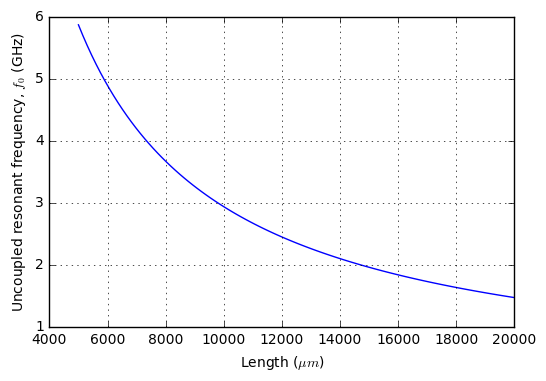

In [169]:
minLen = 5000E-6
maxLen = 20000E-6
length = np.linspace(minLen, maxLen,100)

mCPW = CPWResonator(length=length, 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

plt.plot(length* 10**6, mCPW.uncoupledResonantFrequency / 10**9)
plt.xlabel('Length ($\mu m$)')
plt.ylabel('Uncoupled resonant frequency, $f_0$ (GHz)') 
plt.grid()

### Uncoupled fundamental resonant frequency as a function of temperature

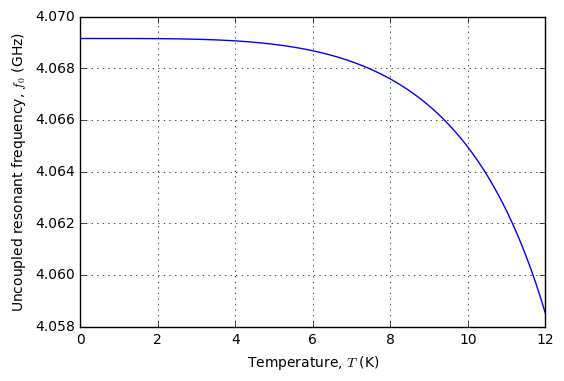

In [170]:
minTemp = 0
maxTemp = 12
temperature = np.linspace(minTemp, maxTemp,100)

mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=temperature, 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

plt.plot(temperature, mCPW.uncoupledResonantFrequency / 10**9)
plt.xlabel('Temperature, $T$ (K)')
plt.ylabel('Uncoupled resonant frequency, $f_0$ (GHz)') 
plt.grid()

### Coupled resonant frequency as a function of coupling capacitance

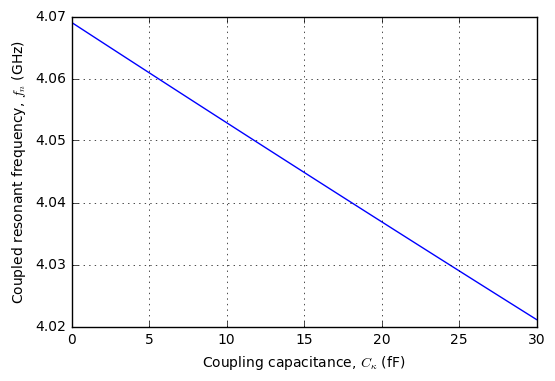

In [171]:
minCap = 0.1E-15
maxCap = 30E-15
couplingCapacitance = np.linspace(minCap, maxCap,100)

mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=couplingCapacitance, 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

plt.plot(couplingCapacitance* 10**15, mCPW.coupledResonantFrequency / 10**9)
plt.xlabel('Coupling capacitance, $C_{\kappa}$ (fF)')
plt.ylabel('Coupled resonant frequency, $f_n$ (GHz)') 
plt.grid()

### External quality factor and insertion loss as a function of coupling capacitance

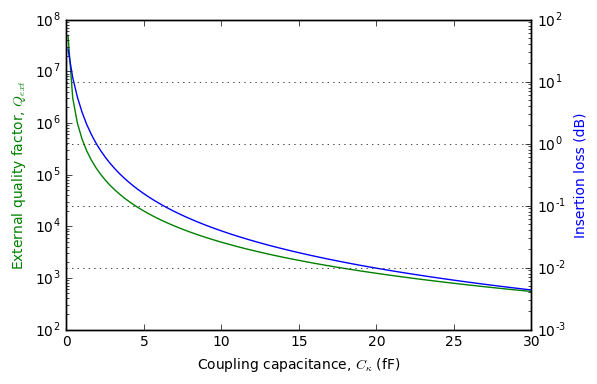

In [172]:
minCap = 0.1E-15
maxCap = 30E-15
couplingCapacitance = np.linspace(minCap, maxCap,100)

mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=couplingCapacitance, 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

fig, ax1 = plt.subplots()
plt.yscale('log')
ax2 = ax1.twinx()
ax1.plot(couplingCapacitance* 10**15, mCPW.externalQualityFactor, 'g-', label="Quality factor")
ax2.plot(couplingCapacitance* 10**15, mCPW.insertionLoss, 'b-', label="Insertion loss")
plt.yscale('log')

ax1.set_xlabel('Coupling capacitance, $C_{\kappa}$ (fF)')
ax1.set_ylabel('External quality factor, $Q_{ext}$', color='g')
ax2.set_ylabel('Insertion loss (dB)', color='b')
plt.grid()

### External quality factor as a function of harmonic mode

/Users/alexmorgan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


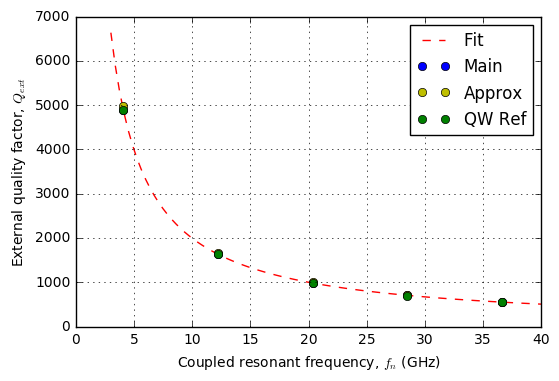

In [173]:
mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=[1,2,3,4,5])

uncoupledResonantFrequency = np.linspace(3,40,100) * 10**9 
externalQualityFactor = mCPW.externalQualityFactorFn(uncoupledResonantFrequency, 
                                                     mCPW.capacitancePerUnitLength, 
                                                     mCPW.length, 
                                                     mCPW.couplingCapacitance)

plt.plot(uncoupledResonantFrequency/10**9, externalQualityFactor, 'r--', label="Fit")
plt.plot(mCPW.uncoupledResonantFrequency/10**9, mCPW.externalQualityFactor, 'bo', label="Main")
plt.plot(mCPW.uncoupledResonantFrequency/10**9, mCPW.externalQualityFactorApprox, 'yo', label="Approx")
plt.plot(mCPW.uncoupledResonantFrequency/10**9, mCPW.externalQualityFactorQWref, 'go', label="QW Ref")
plt.xlabel('Coupled resonant frequency, $f_n$ (GHz)')
plt.ylabel('External quality factor, $Q_{ext}$')
plt.grid()
plt.legend()

## ABCD matrix plots

In [174]:
mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

beta=1.0E-4
freqRange=[0.1E9,400.0E9]
freqStep=0.1E9
frequency= np.arange(freqRange[0], freqRange[1], freqStep)

print('beta', mCPW.beta)

abcd=ABCD(frequency, 
          mCPW.length, 
          mCPW.conductor.amplitudeAttenuationPerUnitLength, 
          beta, # (The value of mCPW.beta is currently too high to give sensible results)
          mCPW.couplingCapacitance, 
          mCPW.characteristicImpedance)
data=abcd.s21

beta [ 217.924]


### Transmission

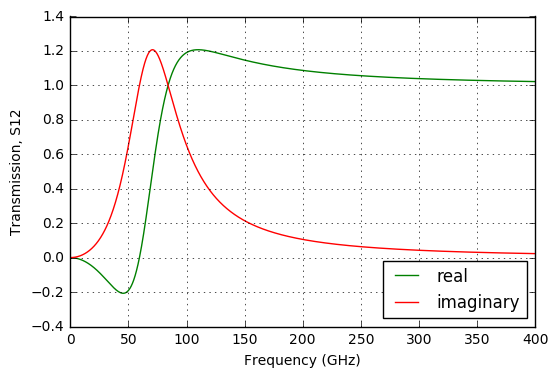

In [175]:
plt.plot(abcd.freq/10**9, np.real(data), 'g-', label='real')
plt.plot(abcd.freq/10**9, np.imag(data), 'r-', label='imaginary')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission, S12')
plt.grid()
plt.legend(loc='lower right')

### Reflection

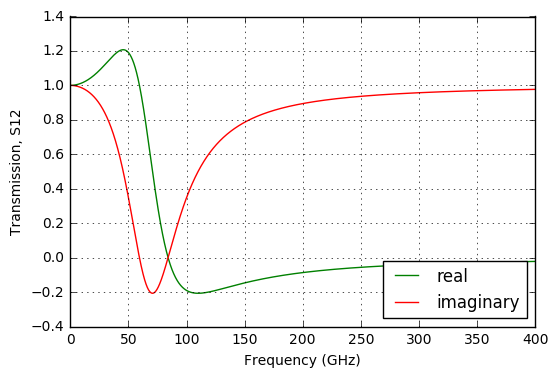

In [176]:
plt.plot(abcd.freq/10**9, 1-np.real(data), 'g-', label='real')
plt.plot(abcd.freq/10**9, 1-np.imag(data), 'r-', label='imaginary')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission, S12')
plt.grid()
plt.legend(loc='lower right')

# 4 - Simulation of CPW resonator using AWR Microwave Studio

AWR Microwave Studio is being used to analytically analyse the behaviour of an ideal quarter-wave co-planar waveguide superconducting microwave resonator. The schematic used to represent this system is shown in Figure 4.1 below,

![title](AWR_QW_schematic.png)
<h6 align="center">Figure 4.1</h6> 

The important parameters are summarised in Table 4.1 below,

  Parameter | Value | Unit
  --- | --- | ---
  Length | 7186 | $\mu m$
  Coupling capacitance, $C_{\kappa}$ | 50 | $fF$
  Conductor width, $W$ | 20 | $\mu m$
  Gap width, $s$ | 10 | $\mu m$
  Substrate | Silicon |
  <h6 align="center">Table 4.1</h6> 

The transmission $S_{12}$ and reflection $S_{11}$ between the two ports due to the presence of the resonator is calculated as,

![title](AWR_QW_graph.png)
<h6 align="center">Figure 4.2</h6> 

This leaves two pieces of the puzzle left,
- What value should be used for the coupling capacitance, $C_{\kappa}$ 
- How to design a coupler with this capacitance

The answer to the former comes down to a trade-off between external quality factor and insertion loss, as seen in one of the figures above. The range of obtainable coupling capacitances is also limited by fabrication restrictions. For example the minimum feature size of photo-lithogrpahy will be around 2-5 $\mu m$ which with a coupler length of 300 $\mu m$ leads to a coupling capacitance of 8-10 $fF$ (as discussed in the next section). Therefore in order to increase the coupling capacitance beyond these values the length of the coupler will need to be increased. However this is also limited because this length should be much less than $\lambda /4$.

## Calculation of coupling capacitance using CST EM Studio

In order to design a coupler with a desired capacitance, it is necessary to use a finite element similuation such as CST EM studio. Below we summarise the results.

The geometry used to simulate the coupling capacitance is illustrated in Figure 4.3 below,

![title](CST_QW_geometry.png)
<h6 align="center">Figure 4.3</h6> 

Electric potentials +1 and -1 were applied to the feedline and resonator respectively. These values were arbitrary and were only set because this is the only way in which I could seem to extract a capacitance matrix. The ground plane was left unassigned and is by default used as the ground reference.

The two variables in this geomtery are the length of the coupler and the width of the gap between the feedline and resonator. Table 4.2 below summarises the capacitances calculated within this parameter space. The capacitances are stated in units of $fF$.


<table border="1">
<tr><td>$\textbf{Coupler length}$ ($\mu m$)</td><td colspan="4">$\textbf{Separation}$ ($\mu m$)</td></tr>
<tr><td></td><td>$\textbf{2}$</td><td>$\textbf{5}$</td><td>$\textbf{10}$</td><td>$\textbf{20}$</td></tr>
<tr><td>$\textbf{200}$</td><td></td><td></td><td></td><td></td></tr>
<tr><td>$\textbf{300}$</td><td>10.14</td><td>8.14</td><td>6.14</td><td>4.01</td></tr>
<tr><td>$\textbf{400}$</td><td>12.86</td><td>10.26</td><td>7.72</td><td>5.00</td></tr>
<tr><td>$\textbf{500}$</td><td></td><td></td><td></td><td></td></tr>
</table>
<h6 align="center">Table 4.2</h6> 

The atoms will couple to the electric field of the resonator. Although the e-field is zero at the grounded end of the resonator, this won't be an issue because we plan to use a higher harmonic mode therefore an e-field maxiumum will be present along the interaction length of the resonator, as shown in Figure 4.4 below,

![title](CST_QW_e-field.png)
<h6 align="center">Figure 4.4</h6> 